[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/time-travel.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239536-lesson-5-time-travel)

# Time travel

## Review

We discussed motivations for human-in-the-loop:

(1) `Approval` - We can interrupt our agent, surface state to a user, and allow the user to accept an action

(2) `Debugging` - We can rewind the graph to reproduce or avoid issues

(3) `Editing` - You can modify the state 

We showed how breakpoints can stop the graph at specific nodes or allow the graph to dynamically interrupt itself.

Then we showed how to proceed with human approval or directly edit the graph state with human feedback.

## Goals

Now, let's show how LangGraph [supports debugging](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/) by viewing, re-playing, and even forking from past states. 

We call this `time travel`.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

Let's build our agent.

In [38]:
from langchain_openai import ChatOpenAI

def celsius_to_fahrenheit(celsius: float) -> float:
    """Convert Celsius to Fahrenheit.

    Args:
        celsius: temperature in Celsius
    """
    return (celsius * 9/5) + 32

# This will be a tool
def kilometers_to_miles(km: float) -> float:
    """Convert kilometers to miles.

    Args:
        km: distance in kilometers
    """
    return km * 0.621371

def meters_to_feet(meters: float) -> float:
    """Convert meters to feet.

    Args:
        meters: distance in meters
    """
    return meters * 3.28084

tools = [celsius_to_fahrenheit, kilometers_to_miles, meters_to_feet]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

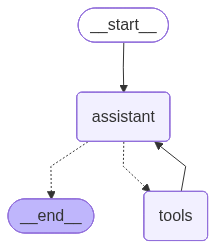

In [39]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing unit conversions for Akshat.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

Let's run it, as before.

In [40]:
# Input
initial_input = {"messages": HumanMessage(content="Convert 20 degrees Celsius to Fahrenheit")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Convert 20 degrees Celsius to Fahrenheit
================================== Ai Message ==================================
Tool Calls:
  celsius_to_fahrenheit (call_Twt0WReM4NgAPqtaNqRJWRk9)
 Call ID: call_Twt0WReM4NgAPqtaNqRJWRk9
  Args:
    celsius: 20
================================= Tool Message =================================
Name: celsius_to_fahrenheit

68.0
================================== Ai Message ==================================
Tool Calls:
  celsius_to_fahrenheit (call_Twt0WReM4NgAPqtaNqRJWRk9)
 Call ID: call_Twt0WReM4NgAPqtaNqRJWRk9
  Args:
    celsius: 20
================================= Tool Message =================================
Name: celsius_to_fahrenheit

68.0
================================== Ai Message ==================================

20 degrees Celsius is equal to 68.0 degrees Fahrenheit.
================================== Ai Message ==================================

2

## Browsing History

We can use `get_state` to look at the **current** state of our graph, given the `thread_id`!

In [41]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Convert 20 degrees Celsius to Fahrenheit', additional_kwargs={}, response_metadata={}, id='0a763dc2-eb5d-43f5-b59c-05832010d257'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Twt0WReM4NgAPqtaNqRJWRk9', 'function': {'arguments': '{"celsius":20}', 'name': 'celsius_to_fahrenheit'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 125, 'total_tokens': 143, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVIlqswC1kMZFA7H7out1x2MOpxSz', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5b894452-b2aa-4b2d-97ec-d9851c086f52-0', tool_calls=[{'name': 'celsius_to_fahrenh

We can also browse the state history of our agent.

`get_state_history` lets us get the state at all prior steps.


In [42]:
all_states = [s for s in graph.get_state_history(thread)]

In [43]:
len(all_states)

5

The first element is the current state, just as we got from `get_state`.

In [44]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Convert 20 degrees Celsius to Fahrenheit', additional_kwargs={}, response_metadata={}, id='0a763dc2-eb5d-43f5-b59c-05832010d257')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b343a-6a60-6367-8000-e4ea90e50314'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-27T14:45:58.856381+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b343a-6a58-6dd5-bfff-2d270e5d80eb'}}, tasks=(PregelTask(id='7a86cd87-f388-fae4-f53f-6be11508e4eb', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Twt0WReM4NgAPqtaNqRJWRk9', 'function': {'arguments': '{"celsius":20}', 'name': 'celsius_to_fahrenheit'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completi

Everything above we can visualize here: 

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

## Replaying 

We can re-run our agent from any of the prior steps.

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

Let's look back at the step that recieved human input!

In [45]:
to_replay = all_states[-2]

In [46]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Convert 20 degrees Celsius to Fahrenheit', additional_kwargs={}, response_metadata={}, id='0a763dc2-eb5d-43f5-b59c-05832010d257')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b343a-6a60-6367-8000-e4ea90e50314'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-10-27T14:45:58.856381+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b343a-6a58-6dd5-bfff-2d270e5d80eb'}}, tasks=(PregelTask(id='7a86cd87-f388-fae4-f53f-6be11508e4eb', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Twt0WReM4NgAPqtaNqRJWRk9', 'function': {'arguments': '{"celsius":20}', 'name': 'celsius_to_fahrenheit'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completi

Look at the state.

In [47]:
to_replay.values

{'messages': [HumanMessage(content='Convert 20 degrees Celsius to Fahrenheit', additional_kwargs={}, response_metadata={}, id='0a763dc2-eb5d-43f5-b59c-05832010d257')]}

We can see the next node to call.

In [49]:
to_replay.next

('assistant',)

We also get the config, which tells us the `checkpoint_id` as well as the `thread_id`.

In [50]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b343a-6a60-6367-8000-e4ea90e50314'}}

To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has aleady been executed. 

It just re-plays from this checkpoint!

In [51]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Convert 20 degrees Celsius to Fahrenheit
================================== Ai Message ==================================
Tool Calls:
  celsius_to_fahrenheit (call_llxW746CZw40HkTcBUAeP1cI)
 Call ID: call_llxW746CZw40HkTcBUAeP1cI
  Args:
    celsius: 20
================================= Tool Message =================================
Name: celsius_to_fahrenheit

68.0
================================== Ai Message ==================================
Tool Calls:
  celsius_to_fahrenheit (call_llxW746CZw40HkTcBUAeP1cI)
 Call ID: call_llxW746CZw40HkTcBUAeP1cI
  Args:
    celsius: 20
================================= Tool Message =================================
Name: celsius_to_fahrenheit

68.0
================================== Ai Message ==================================

20 degrees Celsius is equivalent to 68.0 degrees Fahrenheit.
================================== Ai Message ================================

Now, we can see our current state after the agent re-ran.

## Forking

What if we want to run from that same step, but with a different input.

This is forking.

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [52]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Convert 20 degrees Celsius to Fahrenheit', additional_kwargs={}, response_metadata={}, id='0a763dc2-eb5d-43f5-b59c-05832010d257')]

Again, we have the config.

In [53]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b343a-6a60-6367-8000-e4ea90e50314'}}

Let's modify the state at this checkpoint.

We can just run `update_state` with the `checkpoint_id` supplied. 

Remember how our reducer on `messages` works: 

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

So, to overwrite the the message, we just supply the message ID, which we have `to_fork.values["messages"].id`.

In [54]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Convert 100 meters to feet', 
                               id=to_fork.values["messages"][0].id)]},
)

In [55]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b343e-62fb-60e7-8001-57d4a9976f94'}}

This creates a new, forked checkpoint.
 
But, the metadata - e.g., where to go next - is perserved! 

We can see the current state of our agent has been updated with our fork.

In [56]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Convert 100 meters to feet', additional_kwargs={}, response_metadata={}, id='0a763dc2-eb5d-43f5-b59c-05832010d257')]

In [57]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Convert 100 meters to feet', additional_kwargs={}, response_metadata={}, id='0a763dc2-eb5d-43f5-b59c-05832010d257')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b343e-62fb-60e7-8001-57d4a9976f94'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-10-27T14:47:45.455127+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f0b343a-6a60-6367-8000-e4ea90e50314'}}, tasks=(PregelTask(id='a6443f6b-77ba-a7e6-4f39-65aed91d6f68', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

Now, when we stream, the graph knows this checkpoint has never been executed.

So, the graph runs, rather than simply re-playing.

In [58]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Convert 100 meters to feet
================================== Ai Message ==================================
Tool Calls:
  meters_to_feet (call_lCph0SY9S5SfyETPrFgqCY6L)
 Call ID: call_lCph0SY9S5SfyETPrFgqCY6L
  Args:
    meters: 100
================================= Tool Message =================================
Name: meters_to_feet

328.084
================================== Ai Message ==================================
Tool Calls:
  meters_to_feet (call_lCph0SY9S5SfyETPrFgqCY6L)
 Call ID: call_lCph0SY9S5SfyETPrFgqCY6L
  Args:
    meters: 100
================================= Tool Message =================================
Name: meters_to_feet

328.084
================================== Ai Message ==================================

100 meters is equal to 328.084 feet.
================================== Ai Message ==================================

100 meters is equal to 328.084 feet.


Now, we can see the current state is the end of our agent run.

In [59]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Convert 100 meters to feet', additional_kwargs={}, response_metadata={}, id='0a763dc2-eb5d-43f5-b59c-05832010d257'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_lCph0SY9S5SfyETPrFgqCY6L', 'function': {'arguments': '{"meters":100}', 'name': 'meters_to_feet'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 124, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVInjTa9ImvHMDKfoip95W8jvhJy8', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--57df4b1f-cc08-475d-baf1-0b7f1c4ba45f-0', tool_calls=[{'name': 'meters_to_feet', 'args': {'meters': 100

### Time travel with LangGraph API

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

We connect to it via the SDK and show how the LangGraph API [supports time travel](https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_time_travel/#initial-invocation). 

In [60]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [61]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

#### Re-playing 

Let's run our agent streaming `updates` to the state of the graph after each node is called.

In [62]:
initial_input = {"messages": HumanMessage(content="Convert 50 kilometers to miles")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': 'To convert kilometers to miles, you can use the conversion factor 1 kilometer ≈ 0.621371 miles.\n\nSo, to convert 50 kilometers to miles, you multiply 50 by 0.621371:\n\n50 kilometers × 0.621371 miles/kilometer ≈ 31.06855 miles\n\nThus, 50 kilometers is approximately 31.07 miles.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 80, 'prompt_tokens': 134, 'total_tokens': 214, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVIo7cPSlyLsLOm2O75KnbMSqxS0C', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--3764ba3b-d1ed-40b3-8962-de37c78ce267-0', 'example': False, 'tool

Now, let's look at **replaying** from a specified checkpoint. 

We simply need to pass the `checkpoint_id`.

In [63]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Convert 50 kilometers to miles',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'c8f22d33-3242-4fd6-ad4e-ad7f4cf738b3',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '4d59f782-a57a-a048-99c4-2c16fec3dc01',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': {'messages': [{'content': 'To convert kilometers to miles, you can use the conversion factor 1 kilometer ≈ 0.621371 miles.\n\nSo, to convert 50 kilometers to miles, you multiply 50 by 0.621371:\n\n50 kilometers × 0.621371 miles/kilometer ≈ 31.06855 miles\n\nThus, 50 kilometers is approximately 31.07 miles.',
      'additional_kwargs': {'refusal': None},
      'response_metadata': {'token_usage': {'completion_tokens': 80,
        'prompt_tokens': 134,
        'total_tokens': 214,
        'completion_tokens_deta

Let's stream with `stream_mode="values"` to see the full state at every node as we replay. 

In [64]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):      
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '019a2624-683c-7733-aa6a-a3121d97d44c', 'attempt': 1}



Receiving new event of type: values...
{'messages': [{'content': 'Convert 50 kilometers to miles', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'c8f22d33-3242-4fd6-ad4e-ad7f4cf738b3', 'example': False}]}



Receiving new event of type: values...
{'messages': [{'content': 'Convert 50 kilometers to miles', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'c8f22d33-3242-4fd6-ad4e-ad7f4cf738b3', 'example': False}, {'content': 'To convert kilometers to miles, you can use the conversion factor where 1 kilometer is approximately equal to 0.621371 miles.\n\nTo convert 50 kilometers to miles:\n\\[ 50 \\text{ km} \\times 0.621371 = 31.06855 \\text{ miles} \\]\n\nSo, 50 kilometers is approximately 31.07 miles.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 7

We can all view this as streaming only `updates` to state made by the nodes that we reply.

In [65]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': 'To convert kilometers to miles, you can use the conversion factor where 1 kilometer is approximately equal to 0.621371 miles. \n\nSo, to convert 50 kilometers to miles, you can multiply 50 by 0.621371:\n\n50 kilometers * 0.621371 miles/kilometer ≈ 31.0686 miles.\n\nTherefore, 50 kilometers is approximately equal to 31.07 miles.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 87, 'prompt_tokens': 134, 'total_tokens': 221, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVIoSIhhlUKEVlBrz075p4zanszJb', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--23ffb69f-e43c-4

#### Forking

Now, let's look at forking.

Let's get the same step as we worked with above, the human input.

Let's create a new thread with our agent.

In [67]:
initial_input = {"messages": HumanMessage(content="Convert 30 degrees Celsius to Fahrenheit")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': "To convert Celsius to Fahrenheit, you can use the formula:\n\n\\[ \\text{Fahrenheit} = (\\text{Celsius} \\times \\frac{9}{5}) + 32 \\]\n\nLet's calculate it using this formula. For 30 degrees Celsius:\n\n\\[ \\text{Fahrenheit} = (30 \\times \\frac{9}{5}) + 32 \\]\n\nFirst, we need to multiply 30 by 9/5.\n\n\\[ 30 \\times \\frac{9}{5} = 54 \\]\n\nThen add 32 to the result.\n\n\\[ 54 + 32 = 86 \\]\n\nSo, 30 degrees Celsius is equal to 86 degrees Fahrenheit.", 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 142, 'prompt_tokens': 135, 'total_tokens': 277, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVIolBNq3aj5LVOIfmGL1dY8eAI

In [69]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Convert 30 degrees Celsius to Fahrenheit',
   'additional_kwargs': {},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '027567df-fe19-4099-9067-5ddb90d20ae8',
   'example': False}]}

In [70]:
to_fork['values']['messages'][0]['id']

'027567df-fe19-4099-9067-5ddb90d20ae8'

In [71]:
to_fork['next']

['assistant']

In [72]:
to_fork['checkpoint_id']

'1f0b3441-2230-6f79-8000-2150aa545708'

Let's edit the state.

Remember how our reducer on `messages` works: 

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

In [73]:
forked_input = {"messages": HumanMessage(content="Convert 200 meters to feet",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [74]:
forked_config

{'checkpoint': {'thread_id': '1c1a848d-1608-4dcc-ad4e-c193fac2da55',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3442-324a-6552-8001-348a105bbc0e'},
 'configurable': {'thread_id': '1c1a848d-1608-4dcc-ad4e-c193fac2da55',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0b3442-324a-6552-8001-348a105bbc0e'},
 'checkpoint_id': '1f0b3442-324a-6552-8001-348a105bbc0e'}

In [75]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Convert 200 meters to feet',
    'additional_kwargs': {},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '027567df-fe19-4099-9067-5ddb90d20ae8',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': '2fe308b6-9e29-c98b-5543-cd6771bdc519',
   'name': 'assistant',
   'path': ['__pregel_pull', 'assistant'],
   'error': None,
   'interrupts': [],
   'checkpoint': None,
   'state': None,
   'result': None}],
 'metadata': {'graph_id': 'agent',
  'thread_id': '1c1a848d-1608-4dcc-ad4e-c193fac2da55',
  'checkpoint_id': '1f0b3441-2230-6f79-8000-2150aa545708',
  'checkpoint_ns': '',
  'source': 'update',
  'step': 1,
  'parents': {}},
 'created_at': '2025-10-27T14:49:27.723758+00:00',
 'checkpoint': {'checkpoint_id': '1f0b3442-324a-6552-8001-348a105bbc0e',
  'thread_id': '1c1a848d-1608-4dcc-ad4e-c193fac2da55',
  'checkpoint_ns': ''},
 'parent_checkpoint': {'checkpoint_id': '1f0b3441-2230-6f79-8000-2150aa545708',
  '

To rerun, we pass in the `checkpoint_id`.

In [76]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': 'To convert meters to feet, you can use the conversion factor where 1 meter is approximately equal to 3.281 feet.\n\nSo, to convert 200 meters to feet:\n\n\\(200 \\text{ meters} \\times 3.281 \\text{ feet/meter} = 656.2 \\text{ feet}\\)\n\nTherefore, 200 meters is approximately 656.2 feet.', 'additional_kwargs': {'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 81, 'prompt_tokens': 134, 'total_tokens': 215, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_65564d8ba5', 'id': 'chatcmpl-CVIpS4Z9kOhkxXjwzOQRB0gjrDo6i', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, 'type': 'ai', 'name': None, 'id': 'run--b1fa0759-64d9-40c1-b740-f2aafe434cc3-0', 'example': Fal

### LangGraph Studio

Let's look at forking in the Studio UI with our `agent`, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.